In [1]:
#%pip install -r requirements.txt

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.model_selection import cross_validate, validation_curve, train_test_split, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from mlxtend.evaluate import bias_variance_decomp

In [3]:
df = pd.read_csv("datasets/data2.csv")
print(df.shape)

(1460, 81)


In [4]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
import io
buffer = io.StringIO()
df.info(buf=buffer)
s = buffer.getvalue()
with open("df_info.txt", "w", encoding="utf-8") as f:
    f.write(s)

In [6]:
drop_columns = ["Id", "Alley", "MasVnrType", "FireplaceQu", "PoolQC", "Fence", "MiscFeature"]
df = df.drop(drop_columns, axis=1)
df = df.dropna()
print(df.shape)

(1094, 74)


In [7]:
y = df["SalePrice"]
df = df.drop("SalePrice", axis=1)

In [8]:
standart_scaler = StandardScaler()
y = standart_scaler.fit_transform(y.values.reshape(-1,1)).reshape(-1)

In [9]:
class autoLabelEncoder:
    def __init__(self) -> None:
        self.cat_encoders:dict = {}

    def fit(self, data:pd.DataFrame, categories:list[str]) -> None:
        for feat in categories:
            enc = LabelEncoder()
            self.cat_encoders[feat] = enc.fit(data.loc[data[feat].notna(), feat])

    def transform(self, data:pd.DataFrame, categories:list[str]) -> pd.DataFrame:
        for feat in categories:
            if(feat in data.columns):
                enc = self.cat_encoders[feat]
                data.loc[data[feat].notna(), feat] = (enc.transform(data.loc[data[feat].notna(), feat]))
                data[feat] = data[feat].astype(int)
        return data
    
    def get_encoder(self, category) -> LabelEncoder:
        return self.cat_encoders[category]


In [10]:
objs = df.select_dtypes(include='object')
le = autoLabelEncoder()
le.fit(df, objs)
df = le.transform(df, objs)

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=1)

In [11]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,3,65.0,8450,1,3,3,0,4,0,...,61,0,0,0,0,0,2,2008,8,4
1,20,3,80.0,9600,1,3,3,0,2,0,...,0,0,0,0,0,0,5,2007,8,4
2,60,3,68.0,11250,1,0,3,0,4,0,...,42,0,0,0,0,0,9,2008,8,4
3,70,3,60.0,9550,1,0,3,0,0,0,...,35,272,0,0,0,0,2,2006,8,0
4,60,3,84.0,14260,1,0,3,0,2,0,...,84,0,0,0,0,0,12,2008,8,4


# 1. Выделите обучающую и отложенную выборку. Рассмотрим индивидуальные деревья (4 балла)

### a. Выполните 5-кратную перекрестную проверку, чтобы определить, какой будет наилучшая максимальная глубина для одного дерева регрессии, используя все признаки обучающего набора.

In [12]:
scoring = {'mse': make_scorer(mean_squared_error)}

for depth in range(1,15):
    tree = DecisionTreeRegressor(max_depth=depth, random_state=1)
    print(str(depth) + ":", np.mean(cross_validate(tree,X_train,y_train,cv=5,scoring=scoring)["test_mse"]))

1: 0.5434616474570282
2: 0.39451545101555513
3: 0.32012193889352714
4: 0.2737327837927828
5: 0.28451186311286286
6: 0.2856325298942434
7: 0.29156848672128993
8: 0.30643535391955046
9: 0.307991388785556
10: 0.311526089828445
11: 0.2839907104489118
12: 0.3133558370664691
13: 0.2845165441330303
14: 0.30078149841722784


[]

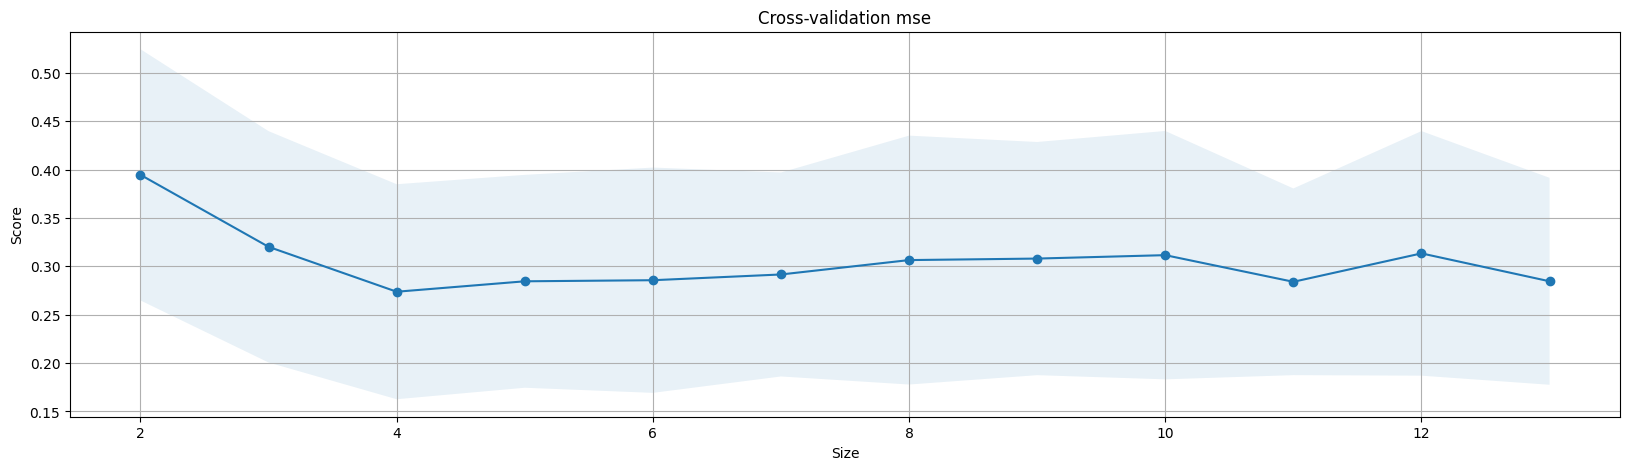

In [13]:
tree = DecisionTreeRegressor(random_state=1)

max_depth_range = list(range(2, 14, 1))
scoring = make_scorer(mean_squared_error)

train_scores, test_scores = validation_curve(
        tree,
        X_train, y_train,
        param_name="max_depth",
        scoring=scoring,
        param_range=max_depth_range,
        cv=5)


def plot_validation_curve(X, y, err, axes = None, x_lab = "", y_lab = "", title = ""):
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(20, 5))
    
    axes.grid()
    axes.plot(X, y, "o-")
    axes.fill_between(
        X,
        y - err,
        y + err,
        alpha=0.1,
    )
    axes.set_xlabel(x_lab)
    axes.set_ylabel(y_lab)
    axes.set_title(title)

    return plt

plot_validation_curve(max_depth_range, np.mean(test_scores, axis=1), np.std(test_scores, axis=1), x_lab="Size", y_lab="Score", title="Cross-validation mse").plot()

### b. Визуализируйте предсказания со средними отклонениями +/- 1 стандартное отклонение во всех наборах перекрестной проверки.

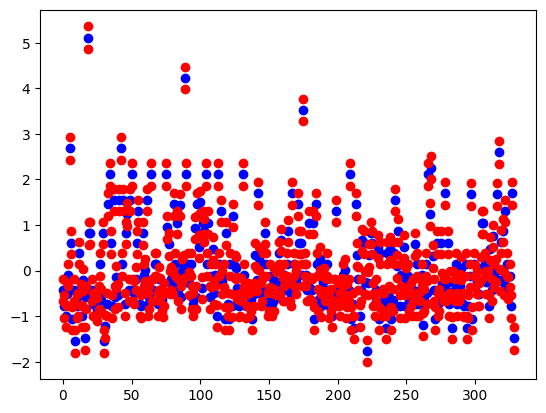

In [14]:
from sklearn.metrics import mean_squared_error

tree = DecisionTreeRegressor(max_depth=8, random_state=1)
tree.fit(X_train,y_train)
pred = tree.predict(X_test)
err = mean_squared_error(pred, y_test)

a = np.arange(0,len(pred),1)
plt.plot(a, pred,'bo')
plt.plot(a, pred-err,'ro')
plt.plot(a, pred+err,'ro',)

In [52]:
max_depth = 26
step=5

arr = np.arange(1,max_depth,step).astype(np.float32)

c=0
#arr = []

for i in range(1, max_depth, step):
    tree = DecisionTreeRegressor(max_depth=i, random_state=1)
    tree.fit(X_train,y_train)
    #arr.append(mean_squared_error(tree.predict(X_test),y_test))
    arr[c]=mean_squared_error(tree.predict(X_test),y_test)
    c+=1

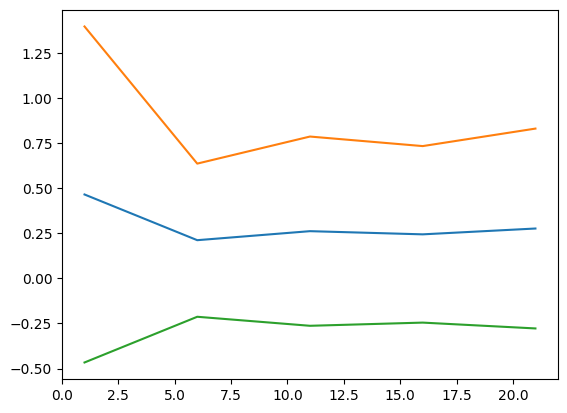

In [57]:
a = np.arange(1,max_depth,step).astype(np.int16)

plt.plot(a,  arr)
plt.plot(a, 3*arr)
plt.plot(a, -1*arr)

### c. Постройте зависимость точности (+/- 2 стандартных отклонения) от числа деревьев

[]

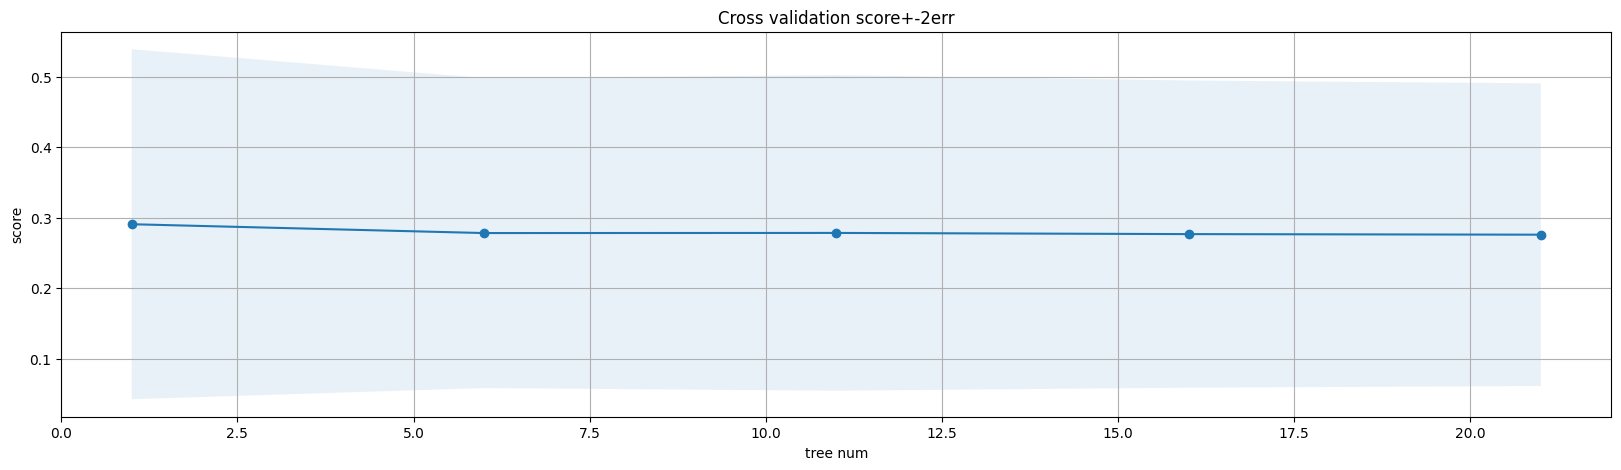

In [63]:
random_fr = RandomForestRegressor(max_depth=6, bootstrap=False, random_state=1)

max_depth_range = list(range(1, 26, 5))
scoring = make_scorer(mean_squared_error)
train_scores, test_scores = validation_curve(
        random_fr,
        X_train, y_train,
        param_name="n_estimators",
        scoring=scoring,
        param_range=max_depth_range,
        cv=5)

err2 = 2*np.std(test_scores, axis=1)

plot_validation_curve(max_depth_range, np.mean(test_scores,axis=1), err2, title="Cross validation score+-2err" , x_lab = "tree num", y_lab = "score").plot()

### d. Визуализируйте предсказания на отложенной выборке. Можно ли получить интервальные предсказания и для нее?

model.predict(X_test) +- mean_squared_error(X_train, y_train)

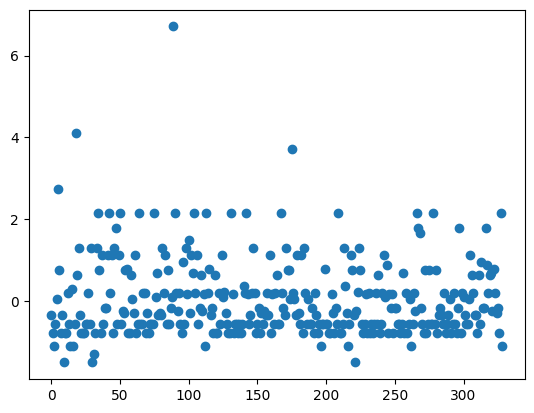

In [103]:
rr = DecisionTreeRegressor(max_depth=6, random_state=1)
pred = rr.fit(X_train,y_train).predict(X_test)
plt.plot(np.arange(0,len(pred),1),pred,'o')

# 2. Перейдите к беггингу. C помощью кросс-валидации постройте и обучите несколько отдельных деревьев (4 балла).

### a. Подведите итоги работы каждого из отдельных деревьев (как численно, так и визуально) с помощью R^2. Как они работают в среднем?

In [100]:
tree_num = 10

My_array = np.arange(tree_num*3).reshape(tree_num, 3).astype(np.float32)

tree = DecisionTreeRegressor(min_samples_leaf=1, max_depth=5) #, random_state=1

for i in range(tree_num):
    cv = cross_validate(tree, X_train, y_train, cv=5, scoring="r2")
    My_array[i] = i, np.mean(cv["test_score"]), np.var(cv["test_score"])

0.7334508
0.0024484692


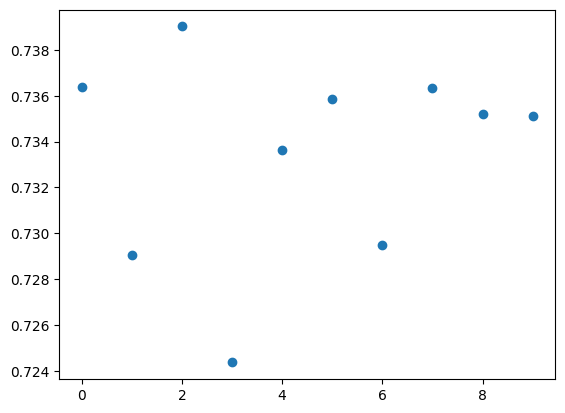

In [101]:
My_arr2 = My_array.transpose(1, 0)

x  = My_arr2[0]
errors = My_arr2[1]
varianses = My_arr2[2]

print(np.mean(errors))
print(np.mean(varianses))
plt.plot(np.arange(0,len(errors),1), errors, 'o')

### b. Объедините деревья в один прогноз с помощью беггинга и оцените его с помощью R^2. Улучшились ли результаты? Оцените, как будет меняться точность в зависимости от глубины. Используйте не только среднее предсказание, но и дисперсию.

In [83]:
for depth in range(1, 6):
    tree = DecisionTreeRegressor(max_depth=depth, min_samples_leaf=1)
    
    br_tree = BaggingRegressor(tree, n_estimators=20, random_state=1)
    
    cv = cross_validate(br_tree, X_train, y_train, cv=5, scoring="r2")
    mean_score = np.mean(cv["test_score"])
    var_score = np.var(cv["test_score"])

    print("Depth:", depth)
    print("  Mean:", mean_score)
    print("  Var:", var_score)

Depth: 1
  Mean: 0.48735853176433397
  Var: 0.005108644157043171
Depth: 2
  Mean: 0.6636977250915187
  Var: 0.00326968351590374
Depth: 3
  Mean: 0.7283747531147905
  Var: 0.003967277573209955
Depth: 4
  Mean: 0.7765171980015619
  Var: 0.0036149406191554115
Depth: 5
  Mean: 0.794228503480076
  Var: 0.0032837610098167013


### c. Постройте графики зависимости bias-variance в зависимости от числа деревьев (до 500 деревьев)

In [91]:
max_tree_num = 501
step=50

tree = DecisionTreeRegressor(max_depth=3, min_samples_leaf=2)

My_array = np.arange(1, (max_tree_num-1)*3, step).reshape(max_tree_num//step, 3).astype(np.float32)
c=0
for i in range(1,501,50):
    br_tree = BaggingRegressor(tree, n_estimators=i)

    X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
    
    _, bias, var = bias_variance_decomp(br_tree, X_train_sub.values, y_train_sub, X_test_sub.values, y_test_sub, loss='mse', num_rounds=10, random_seed=1)
    My_array[c] = (i, bias, var)
    c+=1

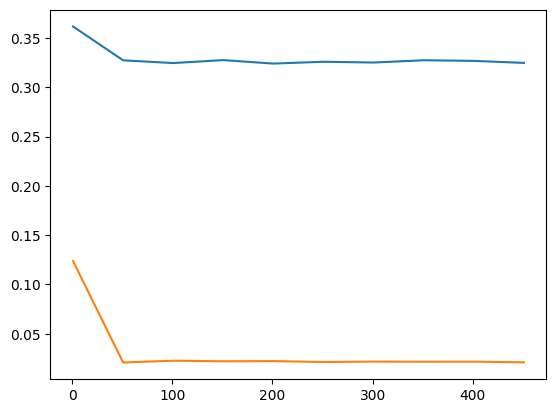

In [94]:
My_arr2 = My_array.transpose(1, 0)
x = My_arr2[0]
biases = My_arr2[1]
vars = My_arr2[2]

plt.plot(x, biases)
plt.plot(x, vars)
#plt.plot()

# 3. Повторите предыдущие шаги, но для случайного леса (4 балла). Можете использовать любую из опций из oob_score и кросс-валидации. Объясните свой выбор.

### 2.a Подведите итоги работы каждого из отдельных деревьев (как численно, так и визуально) с помощью R^2. Как они работают в среднем?

In [105]:
tree_num = 10

My_array = np.arange(tree_num*3).reshape(tree_num, 3).astype(np.float32)

tree = DecisionTreeRegressor(min_samples_leaf=1, max_depth=5) #, random_state=1

for i in range(tree_num):
    cv = cross_validate(tree, X_train, y_train, cv=5, scoring="r2")
    My_array[i] = i, np.mean(cv["test_score"]), np.var(cv["test_score"])

0.7341615
0.0024923724


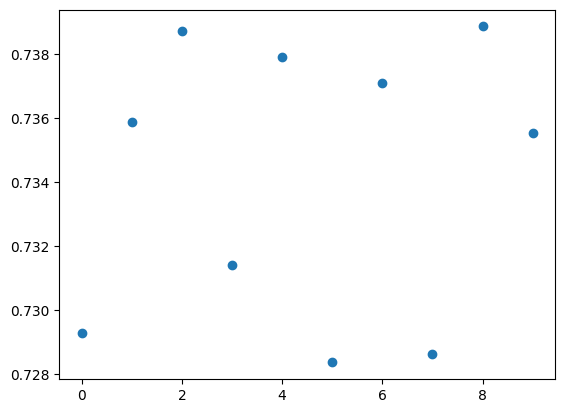

In [106]:
My_arr2 = My_array.transpose(1, 0)

x  = My_arr2[0]
errors = My_arr2[1]
varianses = My_arr2[2]

print(np.mean(errors))
print(np.mean(varianses))
plt.plot(np.arange(0,len(errors),1), errors, 'o')

### 2.b. Объедините деревья в один прогноз с помощью беггинга и оцените его с помощью R^2. Улучшились ли результаты? Оцените, как будет меняться точность в зависимости от глубины. Используйте не только среднее предсказание, но и дисперсию.

In [110]:
for depth in range(1, 6):
    rf_tree = RandomForestRegressor(n_estimators=50, max_depth=depth, random_state=1)
    
    cv = cross_validate(rf_tree, X_train, y_train, cv=5, scoring="r2")
    mean_score = np.mean(cv["test_score"])
    var_score = np.var(cv["test_score"])

    print("Depth:", depth)
    print("  Mean:", mean_score)
    print("  Var:", var_score)

Depth: 1
  Mean: 0.5002780988641845
  Var: 0.005492408528378312
Depth: 2
  Mean: 0.670551779488104
  Var: 0.002955894424169477
Depth: 3
  Mean: 0.7395675940685988
  Var: 0.003740800294336429
Depth: 4
  Mean: 0.7871585746185268
  Var: 0.0031302222435432387
Depth: 5
  Mean: 0.8078257012087626
  Var: 0.003142832716379477


### 2.c. Постройте графики зависимости bias-variance в зависимости от числа деревьев (до 500 деревьев)

In [115]:
max_tree_num = 201
step=50

tree = DecisionTreeRegressor(max_depth=3, min_samples_leaf=2)

My_array = np.arange(1, (max_tree_num-1)*3, step).reshape(max_tree_num//step, 3).astype(np.float32)
c=0
for i in range(1,max_tree_num,step):
    rf_tree = RandomForestRegressor(n_estimators=i,max_depth=3)

    X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
    
    _, bias, var = bias_variance_decomp(rf_tree, X_train_sub.values, y_train_sub, X_test_sub.values, y_test_sub, loss='mse', num_rounds=10, random_seed=1)
    My_array[c] = (i, bias, var)
    c+=1

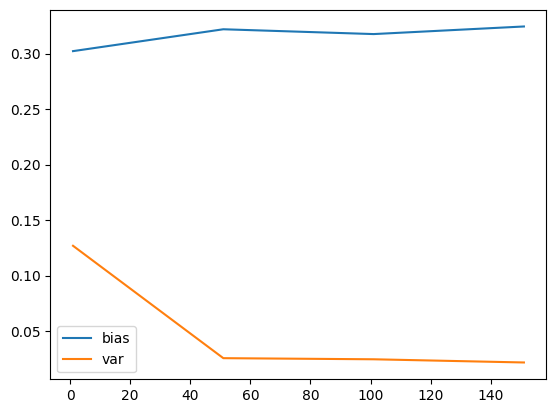

In [119]:
My_arr2 = My_array.transpose(1, 0)
x = My_arr2[0]
biases = My_arr2[1]
vars = My_arr2[2]

plt.plot(x, biases, label = 'bias')
plt.plot(x, vars, label = 'var')
plt.legend()

#plt.plot()

### a. Также оцените важность признаков. Какие 5 признаков наиболее важны?

In [121]:
feature_names = [f"feature {i}" for i in range(X_train.shape[1])]
forest = RandomForestRegressor(random_state=0)
forest.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [147]:
X_train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPor

In [175]:
importances = forest.feature_importances_
std = np.std([forest.estimators_[i].feature_importances_ for i in range(len(forest.estimators_))], axis=0)
indexs = [i for i in X_train.columns]
values = zip(indexs, std)

dtype = [('feature_index', 'S30'), ('feature_importance', float)]
a = np.array(list(values), dtype=dtype)

feature_importances_list = np.sort(a, order='feature_importance')[::-1]

feature_names = []
for feature_name, feature_importance in feature_importances_list[:8]:
    print("feature_name:", feature_name.decode("utf-8"))
    print("feature_importance:", feature_importance)
    feature_names.append(feature_name.decode("utf-8"))



feature_name: OverallQual
feature_importance: 0.057836401286611605
feature_name: 2ndFlrSF
feature_importance: 0.05295085814234886
feature_name: GrLivArea
feature_importance: 0.0396324349367239
feature_name: FullBath
feature_importance: 0.03270162910737596
feature_name: TotalBsmtSF
feature_importance: 0.03161993616995858
feature_name: 1stFlrSF
feature_importance: 0.02573271696327096
feature_name: ExterQual
feature_importance: 0.020299108716280725
feature_name: BsmtFinSF1
feature_importance: 0.018311291967712025


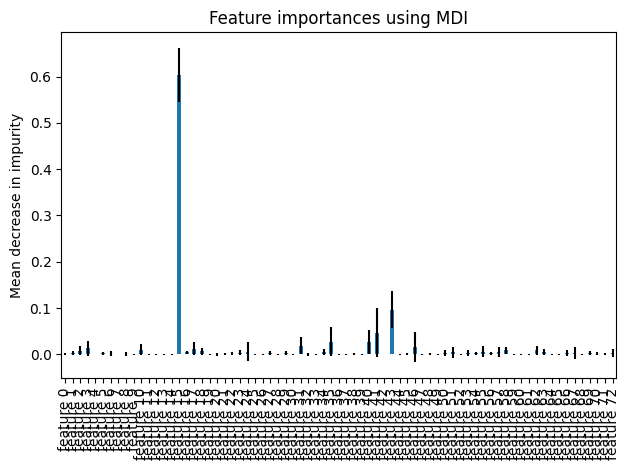

In [123]:
import pandas as pd

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### b. Как изменится результат при использовании только 3/5/8 важнейших признаков?

In [181]:
for i in range(3, 10, 1):
    df2 = df[feature_names[:i]]
    X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df2, y, test_size=0.3, random_state=1)
    
    forest = RandomForestRegressor(random_state=0)
    forest.fit(X_train_2, y_train_2)

    print(i, ":", forest.score(X_test_2, y_test_2))

3 : 0.8008396348442544
4 : 0.8089698209499014
5 : 0.8257186375236822
6 : 0.8185907416371023
7 : 0.8191104713806219
8 : 0.8406496750246997
9 : 0.8406496750246997
